# Lecture 6: Equities — Stock Valuation, the Dividend Discount Model, and Growth Opportunities

## MIT 15.401 — Finance Theory I (Prof. Andrew Lo)

---

**Video:** [MIT OCW — Equities](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/equities/)

**Readings:** Brealey, Myers, and Allen — Chapter 4

---

This session transitions from **fixed-income securities** (known promised cash flows) to **equities** (uncertain cash flows). This is a major conceptual leap: unlike bonds, equity cash flows are not contractually fixed — dividends are uncertain in both magnitude and timing, and the terminal price is unknown. Yet the fundamental valuation framework remains the same: **price = present value of expected future cash flows**.

The workhorse model is the **Dividend Discount Model (DDM)**, which values a stock as the present value of all future dividends. When we add a constant growth assumption, this becomes the **Gordon Growth Model** — one of the most famous formulas in finance: $P_0 = D_1/(r - g)$.

We then connect dividends to earnings through the **payout ratio**, define **growth opportunities**, and show how the **P/E ratio** decomposes into a no-growth component and the **present value of growth opportunities (PVGO)**.

## Table of Contents

1. [Industry Overview — The Equity Market](#1-overview)
2. [The Dividend Discount Model (DDM)](#2-ddm)
3. [The Gordon Growth Model](#3-gordon)
4. [Estimating the Cost of Equity](#4-cost-of-equity)
5. [Multi-Stage Growth Models](#5-multi-stage)
6. [EPS, P/E, and the Link to Earnings](#6-eps-pe)
7. [Growth Opportunities and Growth Stocks](#7-growth)
8. [Exercises](#8-exercises)

In [3]:
# ============================================================
# Setup
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import brentq

plt.rcParams.update({
    'figure.figsize': (10, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'lines.linewidth': 2,
})

print("Libraries loaded successfully.")

Libraries loaded successfully.


---

<a id='1-overview'></a>
## 1. Industry Overview — The Equity Market

### What Is Common Stock?

Common stock represents an **ownership position** (equity) in a corporation. Key characteristics:

- **Residual claimant:** stockholders get paid *after* all other obligations (bondholders, employees, taxes). This makes equity riskier than debt — but also gives unlimited upside.
- **Limited liability:** shareholders can lose at most their investment. They are not personally liable for corporate debts.
- **Voting rights:** shareholders elect the board of directors.
- **Dividends:** payouts in cash or stock, at the discretion of the board. Unlike bond coupons, dividends are **not contractually guaranteed**.
- **Access to public markets:** shares can be bought and sold on exchanges.

### Equity vs. Bonds — The Fundamental Distinction

| Feature | Bonds | Equities |
|---------|-------|----------|
| Cash flows | Contractually fixed | Uncertain |
| Priority | Senior claim | Residual claim |
| Upside | Capped at face value | Unlimited |
| Downside | Loss if default | Can go to zero |
| Tax treatment | Interest is deductible | Dividends paid from after-tax income |
| Maturity | Finite | Perpetual |

### Markets

**Primary market:** IPOs, SEOs, venture capital — companies raise capital by issuing new shares. **Secondary market:** NYSE, NASDAQ, AMEX — investors trade existing shares among themselves. The secondary market provides **liquidity** and **price discovery**.

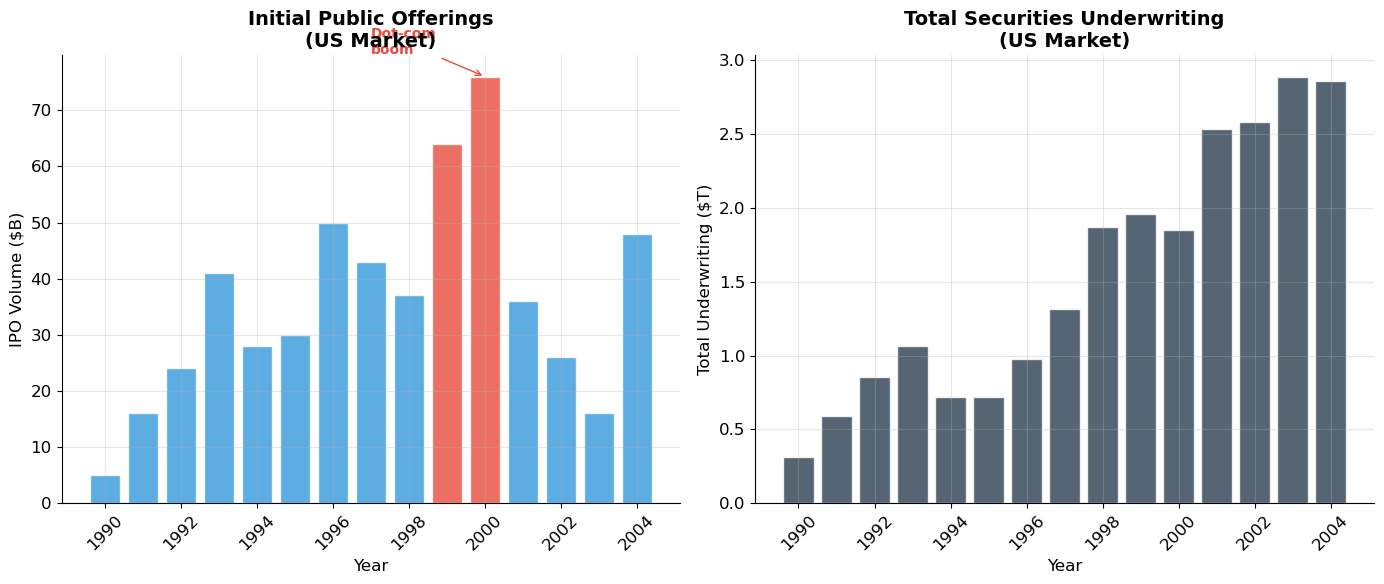

In [5]:
# ============================================================
# Equity Market Scale — IPOs and Market Activity
# ============================================================
# Lo's slide data: IPO volume and total underwriting 1990-2004
years = list(range(1990, 2005))
ipo_volume = [5, 16, 24, 41, 28, 30, 50, 43, 37, 64, 76, 36, 26, 16, 48]  # $B
total_underwriting = [312, 587, 856, 1063, 716, 722, 979, 1317, 1868, 1960, 1851, 2535, 2581, 2890, 2859]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# IPOs
colors_ipo = ['#e74c3c' if v > 60 else '#3498db' for v in ipo_volume]
ax1.bar(years, ipo_volume, color=colors_ipo, alpha=0.8, edgecolor='white')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('IPO Volume ($B)', fontsize=12)
ax1.set_title('Initial Public Offerings\n(US Market)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Highlight dot-com boom
ax1.annotate('Dot-com\nboom', xy=(2000, 76), xytext=(1997, 80),
            fontsize=10, color='#e74c3c', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#e74c3c'))

# Total underwriting
ax2.bar(years, [v/1000 for v in total_underwriting], color='#2c3e50', alpha=0.8, edgecolor='white')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Total Underwriting ($T)', fontsize=12)
ax2.set_title('Total Securities Underwriting\n(US Market)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---

<a id='2-ddm'></a>
## 2. The Dividend Discount Model (DDM)

### The Core Idea

How should we value a stock? The same way we value any asset: as the **present value of its future cash flows**. For a stock, the relevant cash flows are **dividends**.

### One-Period Model

If you hold a stock for one period, you receive a dividend $D_1$ and sell at price $P_1$:

$$P_0 = \frac{D_1 + P_1}{1 + r}$$

But what determines $P_1$? The next investor's expected dividend and resale price:

$$P_1 = \frac{D_2 + P_2}{1 + r}$$

### Multi-Period Model

Substituting recursively and pushing the terminal price to infinity:

$$P_0 = \frac{D_1}{(1+r)} + \frac{D_2}{(1+r)^2} + \frac{D_3}{(1+r)^3} + \cdots = \sum_{t=1}^{\infty} \frac{D_t}{(1+r)^t}$$

This is the **Dividend Discount Model**: the stock price equals the present value of **all future dividends**, to infinity.

### Key Assumptions (for the basic version)

1. **Constant discount rate** $r$ across all periods
2. Dividends are the only relevant cash flows to equity holders
3. The terminal price grows slower than the discount rate (ensuring convergence)

**Critical insight:** Even though any individual investor may hold the stock for a short period and sell it, the price today still equals the PV of all *future* dividends — because the price the next investor pays is itself based on future dividends.

In [7]:
# ============================================================
# One-Period vs. Multi-Period DDM — Equivalence Demonstration
# ============================================================

def ddm_general(dividends, terminal_price, r):
    """Value a stock from a finite list of dividends plus terminal price."""
    T = len(dividends)
    pv = sum(D / (1 + r)**t for t, D in enumerate(dividends, 1))
    pv += terminal_price / (1 + r)**T
    return pv


# Example: constant dividend stream, showing equivalence
r = 0.12
D = 2.00  # constant dividend forever

# Investor 1: holds for 1 year
# P1 = D/r (perpetuity from year 2 onward)
P1 = D / r
P0_1period = ddm_general([D], P1, r)

# Investor 2: holds for 5 years
P5 = D / r  # same perpetuity from year 6
P0_5period = ddm_general([D]*5, P5, r)

# Investor 3: holds forever (perpetuity formula)
P0_forever = D / r

print("=" * 60)
print("DDM EQUIVALENCE: Holding Period Doesn't Matter")
print(f"Constant dividend D = ${D:.2f}, discount rate r = {r:.0%}")
print("=" * 60)
print(f"1-year holding period:  P₀ = (D₁ + P₁)/(1+r) = ({D} + {P1:.2f})/1.12 = ${P0_1period:.4f}")
print(f"5-year holding period:  P₀ = Σ PV(D) + PV(P₅)                       = ${P0_5period:.4f}")
print(f"Infinite holding:       P₀ = D/r = {D}/{r}                            = ${P0_forever:.4f}")
print(f"\n→ All methods give P₀ = ${D/r:.2f} regardless of holding period ✓")
print(f"  The stock price today reflects ALL future dividends, not just")
print(f"  the dividends you personally will receive while holding it.")

DDM EQUIVALENCE: Holding Period Doesn't Matter
Constant dividend D = $2.00, discount rate r = 12%
1-year holding period:  P₀ = (D₁ + P₁)/(1+r) = (2.0 + 16.67)/1.12 = $16.6667
5-year holding period:  P₀ = Σ PV(D) + PV(P₅)                       = $16.6667
Infinite holding:       P₀ = D/r = 2.0/0.12                            = $16.6667

→ All methods give P₀ = $16.67 regardless of holding period ✓
  The stock price today reflects ALL future dividends, not just
  the dividends you personally will receive while holding it.


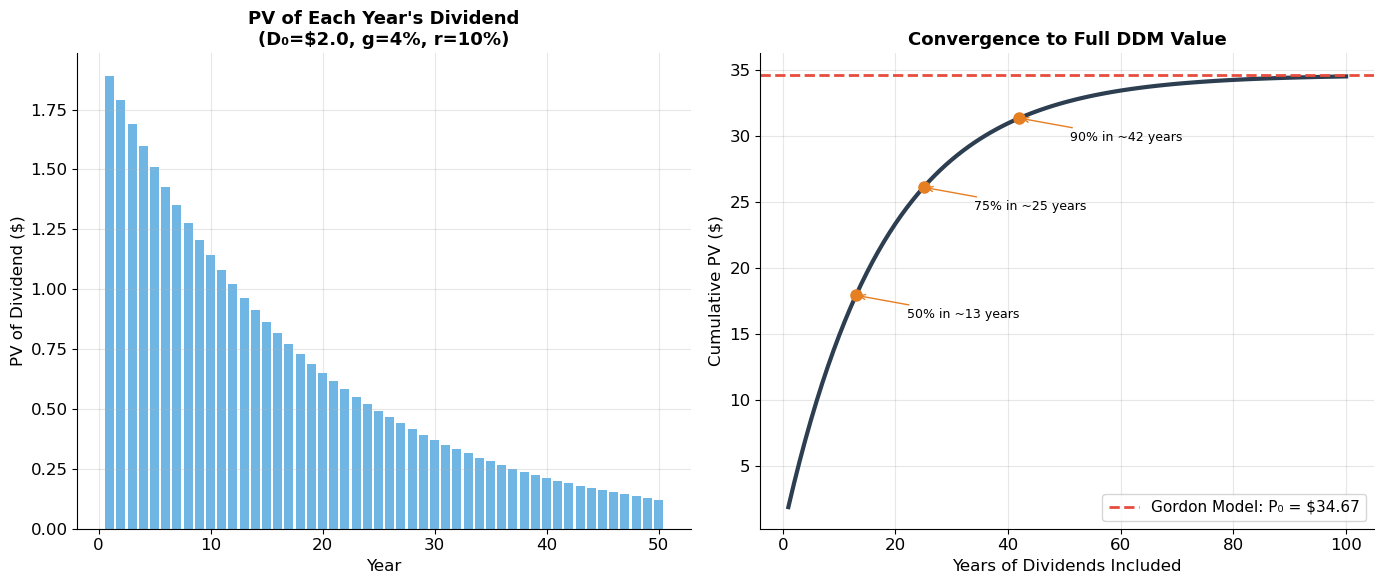

  50% of value captured in first  13 years
  75% of value captured in first  25 years
  90% of value captured in first  42 years
  95% of value captured in first  54 years


In [8]:
# ============================================================
# DDM Convergence: How Much Value Comes From Near vs. Far Dividends?
# ============================================================
# ▶ MODIFY AND RE-RUN
D = 2.00
r = 0.10
g = 0.04  # growth rate
# ============================================================

# Gordon Growth Model value
P0 = D * (1 + g) / (r - g)

# Cumulative PV of dividends from year 1 to T
T_max = 100
cumulative_pv = np.zeros(T_max)
for t in range(1, T_max + 1):
    Dt = D * (1 + g)**t
    cumulative_pv[t-1] = cumulative_pv[t-2] + Dt / (1 + r)**t if t > 1 else Dt / (1 + r)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Individual PV contributions
T_show = 50
pvs = [D * (1 + g)**t / (1 + r)**t for t in range(1, T_show + 1)]
ax1.bar(range(1, T_show + 1), pvs, color='#3498db', alpha=0.7, width=0.8)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('PV of Dividend ($)', fontsize=12)
ax1.set_title(f'PV of Each Year\'s Dividend\n(D₀=${D}, g={g:.0%}, r={r:.0%})', fontsize=13, fontweight='bold')

# Right: Cumulative
years = np.arange(1, T_max + 1)
ax2.plot(years, cumulative_pv, color='#2c3e50', linewidth=3)
ax2.axhline(y=P0, color='#e74c3c', linewidth=2, linestyle='--', label=f'Gordon Model: P₀ = ${P0:.2f}')

# Milestones
for pct in [0.5, 0.75, 0.9]:
    idx = np.searchsorted(cumulative_pv, P0 * pct)
    if idx < T_max:
        ax2.plot(idx + 1, cumulative_pv[idx], 'o', color='#e67e22', markersize=8, zorder=5)
        ax2.annotate(f'{pct:.0%} in ~{idx+1} years', xy=(idx + 1, cumulative_pv[idx]),
                    xytext=(idx + 10, cumulative_pv[idx] - P0 * 0.05), fontsize=9,
                    arrowprops=dict(arrowstyle='->', color='#e67e22'))

ax2.set_xlabel('Years of Dividends Included', fontsize=12)
ax2.set_ylabel('Cumulative PV ($)', fontsize=12)
ax2.set_title('Convergence to Full DDM Value', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

for pct in [0.5, 0.75, 0.9, 0.95]:
    idx = np.searchsorted(cumulative_pv, P0 * pct) + 1
    print(f"  {pct:.0%} of value captured in first {idx:>3d} years")

---

<a id='3-gordon'></a>
## 3. The Gordon Growth Model

### Derivation

If dividends grow at a **constant rate** $g$ forever, with $g < r$:

$$D_t = D_0 (1+g)^t$$

The DDM becomes a **growing perpetuity** (which we derived in Session 2):

$$\boxed{P_0 = \frac{D_1}{r - g} = \frac{D_0(1+g)}{r - g}}$$

This is the **Gordon Growth Model** (Gordon, 1959) — perhaps the single most important formula in equity valuation.

### Lo's Example (Slide 10)

Dividends grow at $g = 6\%$ per year, current dividend $D_0 = \$1$, expected return $r = 20\%$:

$$P_0 = \frac{D_0(1+g)}{r-g} = \frac{1 \times 1.06}{0.20 - 0.06} = \frac{1.06}{0.14} = \$7.57$$

### The Three Determinants of Stock Price

The Gordon model reveals that stock price depends on exactly three things:

1. **$D_1$ (expected next dividend):** higher dividends → higher price
2. **$r$ (required return / cost of equity):** higher risk → lower price
3. **$g$ (dividend growth rate):** higher growth → higher price

And the model gives a precise formula for how sensitive the price is to each.

In [10]:
# ============================================================
# Gordon Growth Model — Core Calculations
# ============================================================

def gordon_growth_price(D0, r, g):
    """Gordon Growth Model: P0 = D0*(1+g)/(r-g). Requires r > g."""
    if r <= g:
        return float('inf')
    return D0 * (1 + g) / (r - g)


# Lo's example
D0 = 1.00
r = 0.20
g = 0.06
P0 = gordon_growth_price(D0, r, g)

print("=" * 60)
print("GORDON GROWTH MODEL — Lo's Example")
print("=" * 60)
print(f"Current dividend D₀ = ${D0:.2f}")
print(f"Growth rate g = {g:.0%}")
print(f"Required return r = {r:.0%}")
print(f"\nP₀ = D₀(1+g)/(r-g) = ${D0}×{1+g:.2f}/({r:.2f}-{g:.2f}) = ${P0:.2f}")

# Sensitivity table
print(f"\n{'':>8s}", end='')
for g_val in [0.02, 0.04, 0.06, 0.08, 0.10, 0.12]:
    print(f"{'g='+f'{g_val:.0%}':>9s}", end='')
print()
print("-" * 62)

for r_val in [0.12, 0.14, 0.16, 0.18, 0.20, 0.25]:
    print(f"r={r_val:.0%}  ", end='')
    for g_val in [0.02, 0.04, 0.06, 0.08, 0.10, 0.12]:
        if r_val > g_val:
            p = gordon_growth_price(1.0, r_val, g_val)
            print(f" ${p:>6.2f}", end='')
        else:
            print(f"     ∞ ", end='')
    print()

print("\nKey insight: Price is EXTREMELY sensitive to (r-g).")
print("A small change in growth or discount rate has a massive impact on valuation.")

GORDON GROWTH MODEL — Lo's Example
Current dividend D₀ = $1.00
Growth rate g = 6%
Required return r = 20%

P₀ = D₀(1+g)/(r-g) = $1.0×1.06/(0.20-0.06) = $7.57

             g=2%     g=4%     g=6%     g=8%    g=10%    g=12%
--------------------------------------------------------------
r=12%   $ 10.20 $ 13.00 $ 17.67 $ 27.00 $ 55.00     ∞ 
r=14%   $  8.50 $ 10.40 $ 13.25 $ 18.00 $ 27.50 $ 56.00
r=16%   $  7.29 $  8.67 $ 10.60 $ 13.50 $ 18.33 $ 28.00
r=18%   $  6.38 $  7.43 $  8.83 $ 10.80 $ 13.75 $ 18.67
r=20%   $  5.67 $  6.50 $  7.57 $  9.00 $ 11.00 $ 14.00
r=25%   $  4.43 $  4.95 $  5.58 $  6.35 $  7.33 $  8.62

Key insight: Price is EXTREMELY sensitive to (r-g).
A small change in growth or discount rate has a massive impact on valuation.


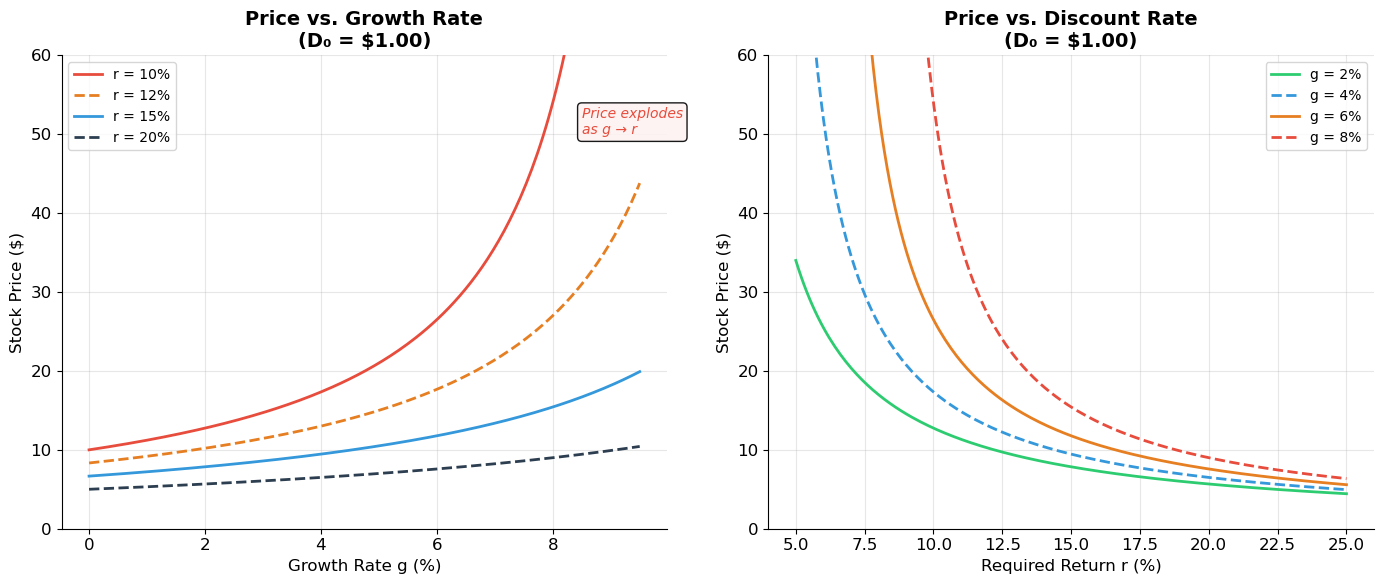

The Gordon model has a singularity at g = r (price → ∞).
In practice, g must be STRICTLY less than r for the model to be valid.
For mature companies, g should not exceed nominal GDP growth (roughly 4-6%).


In [11]:
# ============================================================
# Sensitivity Analysis: Price vs. Growth Rate and Discount Rate
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Price vs. growth rate (fixed r)
g_range = np.linspace(0, 0.095, 200)
for r_val, color, ls in [(0.10, '#e74c3c', '-'), (0.12, '#e67e22', '--'),
                          (0.15, '#3498db', '-'), (0.20, '#2c3e50', '--')]:
    prices = [gordon_growth_price(1.0, r_val, g) for g in g_range]
    ax1.plot(g_range * 100, prices, color=color, linewidth=2, linestyle=ls,
            label=f'r = {r_val:.0%}')

ax1.set_xlabel('Growth Rate g (%)', fontsize=12)
ax1.set_ylabel('Stock Price ($)', fontsize=12)
ax1.set_title('Price vs. Growth Rate\n(D₀ = $1.00)', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 60)
ax1.legend(fontsize=10)
ax1.annotate('Price explodes\nas g → r', xy=(8.5, 50), fontsize=10, color='#e74c3c',
            style='italic', bbox=dict(boxstyle='round', facecolor='#fdf2f2', alpha=0.9))

# Right: Price vs. discount rate (fixed g)
r_range = np.linspace(0.05, 0.25, 200)
for g_val, color, ls in [(0.02, '#2ecc71', '-'), (0.04, '#3498db', '--'),
                          (0.06, '#e67e22', '-'), (0.08, '#e74c3c', '--')]:
    prices = [gordon_growth_price(1.0, r, g_val) if r > g_val else np.nan for r in r_range]
    ax2.plot(r_range * 100, prices, color=color, linewidth=2, linestyle=ls,
            label=f'g = {g_val:.0%}')

ax2.set_xlabel('Required Return r (%)', fontsize=12)
ax2.set_ylabel('Stock Price ($)', fontsize=12)
ax2.set_title('Price vs. Discount Rate\n(D₀ = $1.00)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 60)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("The Gordon model has a singularity at g = r (price → ∞).")
print("In practice, g must be STRICTLY less than r for the model to be valid.")
print("For mature companies, g should not exceed nominal GDP growth (roughly 4-6%).")

---

<a id='4-cost-of-equity'></a>
## 4. Estimating the Cost of Equity from the DDM

### Rearranging the Gordon Model

The Gordon model can be solved for the **discount rate** (cost of equity):

$$\boxed{r = \frac{D_1}{P_0} + g = \text{Dividend Yield} + \text{Growth Rate}}$$

This decomposition is intuitive: the return to an equity investor comes from two sources:
1. **Dividend yield** ($D_1/P_0$): income from dividends
2. **Capital gains** ($g$): price appreciation

### Lo's Duke Power Example (Slide 11)

In September 1992, Duke Power had:
- Dividend yield: $D_0/P_0 = 5.2\%$
- Growth estimates: Value Line (5.0%), IBES (5.5%), historical (4.1%)

$$r = \frac{D_0(1+g)}{P_0} + g \approx \frac{D_1}{P_0} + g$$

Using different growth estimates:

| Source | $g$ | $D_1/P_0$ ≈ $D_0(1+g)/P_0$ | $r = D_1/P_0 + g$ |
|--------|-----|------|------|
| Value Line | 5.0% | ~5.5% | ~10.5% |
| IBES | 5.5% | ~5.5% | ~11.0% |
| Historical | 4.1% | ~5.4% | ~9.5% |

The cost of equity for a utility like Duke Power: roughly **10–11%**.

In [13]:
# ============================================================
# Cost of Equity Estimation — Duke Power Example
# ============================================================
D0_P0 = 0.052  # current dividend yield

growth_estimates = {
    'Value Line': 0.050,
    'IBES Consensus': 0.055,
    'Historical': 0.041,
}

print("=" * 60)
print("COST OF EQUITY — Duke Power (September 1992)")
print("=" * 60)
print(f"Current dividend yield D₀/P₀ = {D0_P0:.1%}")
print()
print(f"{'Source':>18s} {'g':>8s} {'D₁/P₀':>10s} {'r = D₁/P₀ + g':>15s}")
print("-" * 55)

r_estimates = []
for source, g in growth_estimates.items():
    D1_P0 = D0_P0 * (1 + g)
    r = D1_P0 + g
    r_estimates.append(r)
    print(f"{source:>18s} {g:>8.1%} {D1_P0:>10.2%} {r:>15.2%}")

print(f"\nRange of cost of equity estimates: {min(r_estimates):.1%} to {max(r_estimates):.1%}")
print(f"Average: {np.mean(r_estimates):.1%}")
print("\nNote: Duke Power is a regulated utility — low risk, stable dividends.")
print("Its cost of equity is correspondingly modest (~10%) compared to")
print("high-growth tech firms (which might have r = 15-20%).")

COST OF EQUITY — Duke Power (September 1992)
Current dividend yield D₀/P₀ = 5.2%

            Source        g      D₁/P₀   r = D₁/P₀ + g
-------------------------------------------------------
        Value Line     5.0%      5.46%          10.46%
    IBES Consensus     5.5%      5.49%          10.99%
        Historical     4.1%      5.41%           9.51%

Range of cost of equity estimates: 9.5% to 11.0%
Average: 10.3%

Note: Duke Power is a regulated utility — low risk, stable dividends.
Its cost of equity is correspondingly modest (~10%) compared to
high-growth tech firms (which might have r = 15-20%).


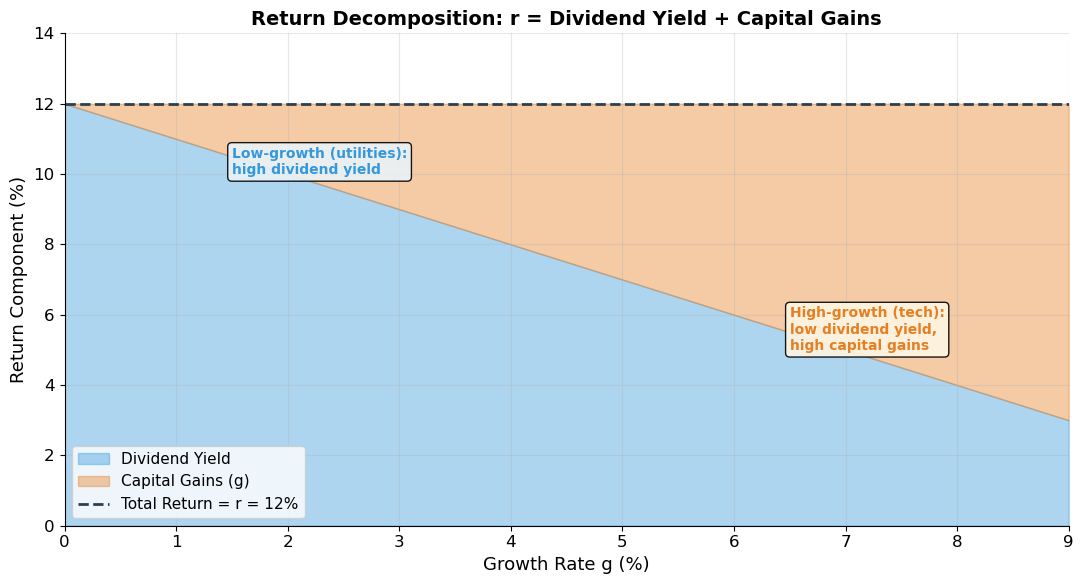

The total return is always r (by the Gordon model: r = D₁/P₀ + g).
As growth increases, the mix shifts from dividend yield to capital gains.
This is why growth stocks have low dividend yields — it's not a flaw!


In [14]:
# ============================================================
# Return Decomposition: Dividend Yield vs. Capital Gains
# ============================================================
# Show how return composition changes with growth rate

g_range = np.linspace(0, 0.09, 200)
r_fixed = 0.12
D0 = 1.0

div_yields = np.array([D0 * (1 + g) / gordon_growth_price(D0, r_fixed, g) if r_fixed > g else np.nan for g in g_range])
cap_gains = g_range

fig, ax = plt.subplots(figsize=(11, 6))

ax.fill_between(g_range * 100, 0, div_yields * 100, alpha=0.4, color='#3498db', label='Dividend Yield')
ax.fill_between(g_range * 100, div_yields * 100, (div_yields + cap_gains) * 100,
                alpha=0.4, color='#e67e22', label='Capital Gains (g)')

ax.axhline(y=r_fixed * 100, color='#2c3e50', linewidth=2, linestyle='--', label=f'Total Return = r = {r_fixed:.0%}')

ax.set_xlabel('Growth Rate g (%)', fontsize=13)
ax.set_ylabel('Return Component (%)', fontsize=13)
ax.set_title('Return Decomposition: r = Dividend Yield + Capital Gains',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim(0, 14)
ax.set_xlim(0, 9)

# Annotations
ax.annotate('Low-growth (utilities):\nhigh dividend yield', xy=(1.5, 10), fontsize=10,
            color='#3498db', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='#eaf2f8', alpha=0.9))
ax.annotate('High-growth (tech):\nlow dividend yield,\nhigh capital gains', xy=(6.5, 5), fontsize=10,
            color='#e67e22', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='#fdf6e3', alpha=0.9))

plt.tight_layout()
plt.show()

print("The total return is always r (by the Gordon model: r = D₁/P₀ + g).")
print("As growth increases, the mix shifts from dividend yield to capital gains.")
print("This is why growth stocks have low dividend yields — it's not a flaw!")

---

<a id='5-multi-stage'></a>
## 5. Multi-Stage Growth Models

### Why Multi-Stage?

The constant-growth assumption is unrealistic for many companies. Firms typically pass through distinct phases:

1. **Growth stage:** rapid expansion, high profit margins, heavy reinvestment, low dividend payout
2. **Transition stage:** competition erodes margins, growth slows, investment opportunities decline
3. **Mature stage:** stable growth, high payout ratio, earnings grow at or below GDP rate

### Two-Stage DDM

The most common variant assumes high growth $g_H$ for $T$ years, then stable growth $g_L$ forever:

$$\boxed{P_0 = \underbrace{\sum_{t=1}^{T} \frac{D_0(1+g_H)^t}{(1+r)^t}}_{\text{High-growth phase}} + \underbrace{\frac{P_T}{(1+r)^T}}_{\text{Terminal value}}}$$

where the terminal value uses the Gordon model:

$$P_T = \frac{D_T(1+g_L)}{r - g_L} = \frac{D_0(1+g_H)^T(1+g_L)}{r - g_L}$$

### Lo's Example (Slide 12)

A company with $D_0 = \$1$, $r = 20\%$ grows at $g_H = 6\%$ for 7 years, then $g_L = 0\%$ thereafter.

In [16]:
# ============================================================
# Two-Stage Growth DDM
# ============================================================

def two_stage_ddm(D0, r, g_high, T_high, g_low):
    """Two-stage DDM: high growth for T years, then stable growth forever."""
    # Phase 1: high-growth dividends
    phase1_pv = 0
    DT = D0
    for t in range(1, T_high + 1):
        DT = D0 * (1 + g_high)**t
        phase1_pv += DT / (1 + r)**t
    
    # Phase 2: terminal value using Gordon model
    D_terminal = DT * (1 + g_low)
    P_T = D_terminal / (r - g_low) if r > g_low else float('inf')
    phase2_pv = P_T / (1 + r)**T_high
    
    return phase1_pv, phase2_pv, phase1_pv + phase2_pv


# Lo's example
D0 = 1.00
r = 0.20
g_H = 0.06
T = 7
g_L = 0.00

pv1, pv2, P0 = two_stage_ddm(D0, r, g_H, T, g_L)

print("=" * 60)
print("TWO-STAGE DDM — Lo's Example")
print("=" * 60)
print(f"D₀ = ${D0:.2f}, r = {r:.0%}, g_H = {g_H:.0%} (years 1–{T}), g_L = {g_L:.0%} (year {T+1}+)")
print()

# Show dividend timeline
print("Dividend timeline:")
for t in range(1, T + 2):
    Dt = D0 * (1 + g_H)**min(t, T)
    if t > T:
        Dt = D0 * (1 + g_H)**T * (1 + g_L)
    phase = "← high growth" if t <= T else "← stable"
    print(f"  D_{t} = ${Dt:.4f}  {phase}")
    if t == T + 1:
        break

# Terminal price
D_T = D0 * (1 + g_H)**T
P_T = D_T * (1 + g_L) / (r - g_L)

print(f"\nTerminal value at T={T}: P_{T} = D_{T+1}/(r-g_L) = ${D_T*(1+g_L):.4f}/{r-g_L:.2f} = ${P_T:.2f}")
print(f"\nPV of high-growth dividends (years 1–{T}): ${pv1:.4f}")
print(f"PV of terminal value:                      ${pv2:.4f}")
print(f"Total stock price P₀:                      ${P0:.4f}")
print(f"\nTerminal value share: {pv2/(pv1+pv2)*100:.1f}% of total value")

# Compare with pure Gordon models
P0_allhigh = gordon_growth_price(D0, r, g_H)
P0_no_growth = D0 * (1 + 0) / (r - 0)  # g=0 forever

print(f"\nComparison:")
print(f"  If g = {g_H:.0%} forever:   P₀ = ${P0_allhigh:.2f}")
print(f"  Two-stage model:     P₀ = ${P0:.2f}")
print(f"  If g = {g_L:.0%} forever:   P₀ = ${P0_no_growth:.2f}")

TWO-STAGE DDM — Lo's Example
D₀ = $1.00, r = 20%, g_H = 6% (years 1–7), g_L = 0% (year 8+)

Dividend timeline:
  D_1 = $1.0600  ← high growth
  D_2 = $1.1236  ← high growth
  D_3 = $1.1910  ← high growth
  D_4 = $1.2625  ← high growth
  D_5 = $1.3382  ← high growth
  D_6 = $1.4185  ← high growth
  D_7 = $1.5036  ← high growth
  D_8 = $1.5036  ← stable

Terminal value at T=7: P_7 = D_8/(r-g_L) = $1.5036/0.20 = $7.52

PV of high-growth dividends (years 1–7): $4.3942
PV of terminal value:                      $2.0982
Total stock price P₀:                      $6.4924

Terminal value share: 32.3% of total value

Comparison:
  If g = 6% forever:   P₀ = $7.57
  Two-stage model:     P₀ = $6.49
  If g = 0% forever:   P₀ = $5.00


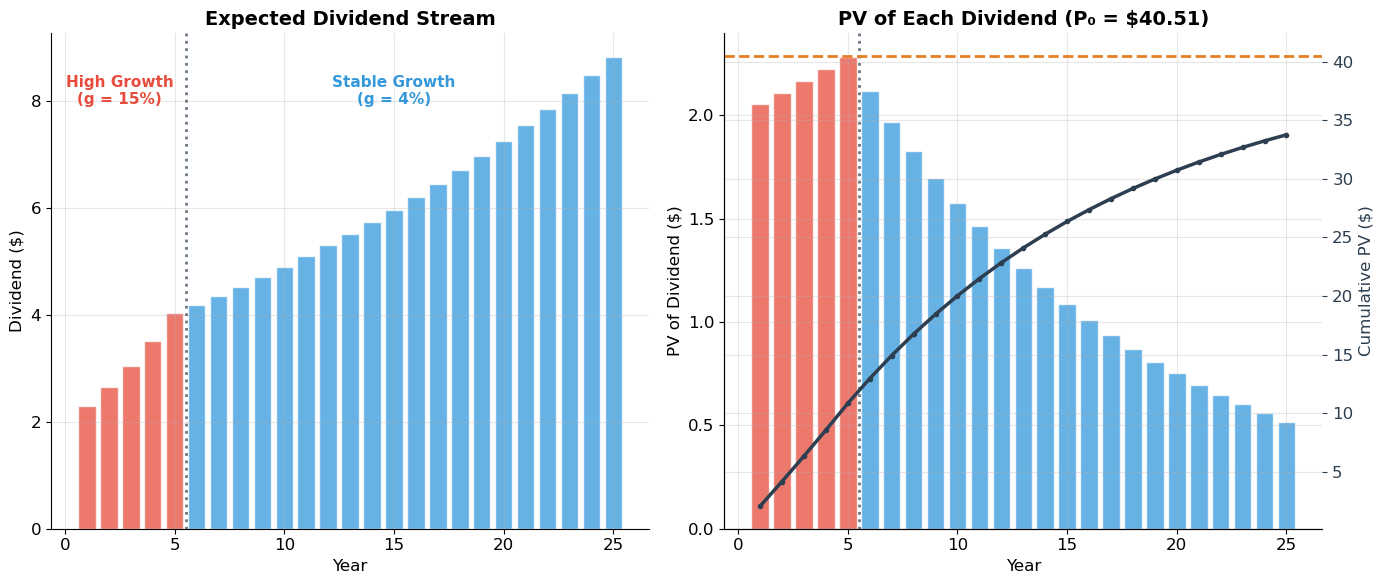

Two-stage DDM: P₀ = $40.51
  PV of high-growth dividends: $10.83 (26.7%)
  PV of terminal value:        $29.67 (73.3%)

The terminal value typically dominates — most of a stock's value
comes from the LONG-RUN growth phase, not the near-term high growth.


In [17]:
# ============================================================
# Visualization: Two-Stage DDM Cash Flows and Valuation
# ============================================================
# ▶ MODIFY AND RE-RUN
D0 = 2.00
r = 0.12
g_high = 0.15     # high-growth phase
T_high = 5        # years of high growth
g_low = 0.04      # stable growth
# ============================================================

pv1, pv2, P0 = two_stage_ddm(D0, r, g_high, T_high, g_low)

# Build dividend series
T_plot = 25
divs = []
pvs = []
for t in range(1, T_plot + 1):
    if t <= T_high:
        Dt = D0 * (1 + g_high)**t
    else:
        Dt = D0 * (1 + g_high)**T_high * (1 + g_low)**(t - T_high)
    divs.append(Dt)
    pvs.append(Dt / (1 + r)**t)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Dividend timeline
years_plot = range(1, T_plot + 1)
colors_bar = ['#e74c3c' if t <= T_high else '#3498db' for t in years_plot]
ax1.bar(years_plot, divs, color=colors_bar, alpha=0.75, edgecolor='white')
ax1.axvline(x=T_high + 0.5, color='#2c3e50', linewidth=2, linestyle=':', alpha=0.7)
ax1.text(T_high / 2, max(divs) * 0.9, f'High Growth\n(g = {g_high:.0%})',
         ha='center', fontsize=11, color='#e74c3c', fontweight='bold')
ax1.text(T_high + (T_plot - T_high) / 2, max(divs) * 0.9, f'Stable Growth\n(g = {g_low:.0%})',
         ha='center', fontsize=11, color='#3498db', fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Dividend ($)', fontsize=12)
ax1.set_title('Expected Dividend Stream', fontsize=14, fontweight='bold')

# Right: PV contributions
ax2.bar(years_plot, pvs, color=colors_bar, alpha=0.75, edgecolor='white')
ax2.axvline(x=T_high + 0.5, color='#2c3e50', linewidth=2, linestyle=':', alpha=0.7)

# Show cumulative reaching total
cumulative = np.cumsum(pvs)
ax2_twin = ax2.twinx()
ax2_twin.plot(years_plot, cumulative, color='#2c3e50', linewidth=2.5, marker='o', markersize=3)
ax2_twin.axhline(y=P0, color='#e67e22', linewidth=2, linestyle='--')
ax2_twin.set_ylabel('Cumulative PV ($)', fontsize=12, color='#2c3e50')
ax2_twin.tick_params(axis='y', colors='#2c3e50')

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('PV of Dividend ($)', fontsize=12)
ax2.set_title(f'PV of Each Dividend (P₀ = ${P0:.2f})', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Two-stage DDM: P₀ = ${P0:.2f}")
print(f"  PV of high-growth dividends: ${pv1:.2f} ({pv1/P0*100:.1f}%)")
print(f"  PV of terminal value:        ${pv2:.2f} ({pv2/P0*100:.1f}%)")
print(f"\nThe terminal value typically dominates — most of a stock's value")
print(f"comes from the LONG-RUN growth phase, not the near-term high growth.")

---

<a id='6-eps-pe'></a>
## 6. EPS, P/E, and the Link to Earnings

### From Dividends to Earnings

In practice, forecasting individual dividends is difficult. Analysts often work with **earnings** and **payout ratios** instead.

### Key Definitions

| Concept | Symbol | Definition |
|---------|--------|------------|
| **Earnings per share** | EPS | Net income / shares outstanding |
| **Payout ratio** | $p$ | DPS / EPS (fraction of earnings paid as dividends) |
| **Plowback (retention) ratio** | $b$ | 1 − $p$ (fraction reinvested) |
| **Book value per share** | BV | Cumulative retained earnings per share |
| **Return on book equity** | ROE | EPS / BV |

### The Sustainable Growth Rate

If a company reinvests fraction $b$ of earnings at return ROE:

$$\boxed{g = b \times \text{ROE} = (1 - p) \times \text{ROE}}$$

This is the **sustainable growth rate** — the rate at which earnings (and dividends) can grow without external financing.

### Lo's Texas Western Example (Slides 14–16)

Texas Western (TW) has:
- Expected EPS₁ = \$1.00, Book Value = \$10.00
- Plans to grow net book assets by 8% per year (financed by retained earnings)
- Discount rate $r$ = 10% = ROE

Key ratios:
- Plowback ratio: $b = BV \times g / EPS = 10 \times 0.08 / 1 = 0.80$
- Payout ratio: $p = 1 - 0.8 = 0.20$
- ROE = EPS / BV = 1/10 = 10%
- Sustainable growth: $g = b \times ROE = 0.8 \times 0.10 = 0.08$ ✓

In [19]:
# ============================================================
# Texas Western Example — EPS, Growth, and Valuation
# ============================================================

# Company parameters
EPS1 = 1.00
BV0 = 10.00
g = 0.08
r = 0.10
ROE = EPS1 / BV0  # = 10%
b = BV0 * g / EPS1  # plowback ratio
p = 1 - b             # payout ratio
D1 = EPS1 * p         # dividend per share

print("=" * 60)
print("TEXAS WESTERN — Lo's Example")
print("=" * 60)
print(f"EPS₁ = ${EPS1:.2f},  BV₀ = ${BV0:.2f}")
print(f"ROE = EPS/BV = {ROE:.0%}")
print(f"Growth rate g = {g:.0%}")
print(f"Plowback ratio b = {b:.2f}")
print(f"Payout ratio p = {p:.2f}")
print(f"DPS₁ = EPS × p = ${D1:.2f}")
print(f"Sustainable growth: b × ROE = {b:.2f} × {ROE:.2f} = {b * ROE:.0%} = g ✓")

# CASE 1: Expand at 8% forever
P0_case1 = D1 / (r - g)
print(f"\nCase 1: Expand at {g:.0%} forever")
print(f"  P₀ = D₁/(r-g) = {D1}/{r}-{g} = ${P0_case1:.2f}")
print(f"  P/E = {P0_case1/EPS1:.1f}×")

# CASE 2: Growth slows to 4% after year 5
g_high = 0.08
g_low = 0.04
T_trans = 5

# Build explicit year-by-year forecast
print(f"\nCase 2: {g_high:.0%} for {T_trans} years, then {g_low:.0%}")
print(f"\n{'Year':>6s} {'BV_start':>10s} {'EPS':>8s} {'Inv':>8s} {'DPS':>8s} {'b':>6s}")
print("-" * 55)

# Phase 1
BV_t = BV0
EPS_t = EPS1
pv_divs = 0
for t in range(1, T_trans + 1):
    EPS_t = BV_t * ROE
    inv_t = BV_t * g_high
    D_t = EPS_t - inv_t
    pv_divs += D_t / (1 + r)**t
    b_t = inv_t / EPS_t
    print(f"{t:>6d} {BV_t:>10.4f} {EPS_t:>8.4f} {inv_t:>8.4f} {D_t:>8.4f} {b_t:>6.2f}")
    BV_t = BV_t * (1 + g_high)

# Terminal value: from year T+1, ROE still 10% but growth drops to 4%
# New plowback: b_new = g_low / ROE
b_new = g_low / ROE
p_new = 1 - b_new
EPS_T1 = BV_t * ROE
D_T1 = EPS_T1 * p_new
P_T = D_T1 / (r - g_low)
pv_terminal = P_T / (1 + r)**T_trans

P0_case2 = pv_divs + pv_terminal

print(f"\nAt year {T_trans+1}: EPS = ${EPS_T1:.4f}, new payout = {p_new:.0%}, DPS = ${D_T1:.4f}")
print(f"Terminal price: P_{T_trans} = ${P_T:.2f}")
print(f"\nPV of dividends (years 1-{T_trans}): ${pv_divs:.2f}")
print(f"PV of terminal value:            ${pv_terminal:.2f}")
print(f"Stock price P₀:                  ${P0_case2:.2f}")
print(f"P/E = {P0_case2/EPS1:.1f}×")

print(f"\n→ BOTH cases give P₀ = ${P0_case1:.2f}! Why?")
print(f"  Because ROE = r = {ROE:.0%}. When the firm earns EXACTLY its cost of")
print(f"  capital on new investments, growth adds NO value.")
print(f"  Price = EPS₁/r = ${EPS1/r:.2f} regardless of growth strategy.")

TEXAS WESTERN — Lo's Example
EPS₁ = $1.00,  BV₀ = $10.00
ROE = EPS/BV = 10%
Growth rate g = 8%
Plowback ratio b = 0.80
Payout ratio p = 0.20
DPS₁ = EPS × p = $0.20
Sustainable growth: b × ROE = 0.80 × 0.10 = 8% = g ✓

Case 1: Expand at 8% forever
  P₀ = D₁/(r-g) = 0.19999999999999996/0.1-0.08 = $10.00
  P/E = 10.0×

Case 2: 8% for 5 years, then 4%

  Year   BV_start      EPS      Inv      DPS      b
-------------------------------------------------------
     1    10.0000   1.0000   0.8000   0.2000   0.80
     2    10.8000   1.0800   0.8640   0.2160   0.80
     3    11.6640   1.1664   0.9331   0.2333   0.80
     4    12.5971   1.2597   1.0078   0.2519   0.80
     5    13.6049   1.3605   1.0884   0.2721   0.80

At year 6: EPS = $1.4693, new payout = 60%, DPS = $0.8816
Terminal price: P_5 = $14.69

PV of dividends (years 1-5): $0.88
PV of terminal value:            $9.12
Stock price P₀:                  $10.00
P/E = 10.0×

→ BOTH cases give P₀ = $10.00! Why?
  Because ROE = r = 10%. When

---

<a id='7-growth'></a>
## 7. Growth Opportunities and Growth Stocks

### The PVGO Decomposition

Lo shows that any stock price can be decomposed into two components:

$$\boxed{P_0 = \underbrace{\frac{EPS_1}{r}}_{\text{No-growth value}} + \underbrace{PVGO}_{\text{Growth opportunities}}}$$

- **No-growth value** ($EPS_1/r$): the price if the firm distributed all earnings as dividends — no reinvestment, no growth
- **PVGO** (Present Value of Growth Opportunities): the additional value created by reinvesting at returns above the cost of capital

### When Does Growth Create Value?

**Growth is valuable only when ROE > r** — that is, when the firm can reinvest at a rate of return that *exceeds* what investors require.

If ROE = $r$: PVGO = 0, and $P_0 = EPS_1/r$ (the Texas Western result!)

If ROE < $r$: PVGO < 0, and growth actually *destroys* value. The firm would be worth more if it stopped investing and paid out all earnings.

### What Is a "Growth Stock"?

A **growth stock** is NOT merely a stock with growing EPS, growing dividends, or growing assets. It is a stock of a company with access to investments earning **more than the cost of capital** (ROE > $r$), so PVGO > 0.

Counterintuitively:
- A stock with fast-growing EPS might NOT be a growth stock (if ROE < $r$)
- A stock with slow-growing EPS MIGHT be a growth stock (if ROE > $r$)

### The P/E Ratio and PVGO

Dividing both sides by $EPS_1$:

$$\frac{P_0}{EPS_1} = \frac{1}{r} + \frac{PVGO}{EPS_1}$$

This explains why high P/E ratios indicate growth stocks: **P/E > 1/r implies PVGO > 0**.

In [21]:
# ============================================================
# Lo's ABC Software Example — PVGO Decomposition
# ============================================================
# From slide 18
EPS1_abc = 8.33
p_abc = 0.6        # payout ratio
ROE_abc = 0.25     # return on equity
r_abc = 0.15       # cost of capital

b_abc = 1 - p_abc  # plowback ratio = 0.4
g_abc = b_abc * ROE_abc  # sustainable growth = 10%
D1_abc = EPS1_abc * p_abc

print("=" * 65)
print("ABC SOFTWARE — Growth Opportunities (Lo's Example)")
print("=" * 65)
print(f"EPS₁ = ${EPS1_abc:.2f},  payout = {p_abc:.0%},  ROE = {ROE_abc:.0%},  r = {r_abc:.0%}")
print(f"Plowback b = {b_abc:.1f},  g = b × ROE = {b_abc:.1f} × {ROE_abc:.0%} = {g_abc:.0%}")
print(f"D₁ = EPS × p = ${D1_abc:.2f}")

# No-growth value
P0_nogrowth = EPS1_abc / r_abc
print(f"\nNo-growth value: EPS₁/r = ${EPS1_abc:.2f}/{r_abc:.2f} = ${P0_nogrowth:.2f}")

# Growth value
P0_growth = D1_abc / (r_abc - g_abc)
print(f"Growth value:    D₁/(r-g) = ${D1_abc:.2f}/({r_abc:.2f}-{g_abc:.2f}) = ${P0_growth:.2f}")

PVGO = P0_growth - P0_nogrowth
print(f"\nPVGO = P₀(growth) - P₀(no-growth) = ${P0_growth:.2f} - ${P0_nogrowth:.2f} = ${PVGO:.2f}")
print(f"PVGO share: {PVGO/P0_growth*100:.1f}% of stock price")

# Verify PVGO via NPV of growth investments
# At t=1: invest b*EPS = 0.4*8.33 = 3.33 at ROE=25% → perpetual CF of 0.25*3.33 = 0.83
inv_1 = b_abc * EPS1_abc
cf_from_inv1 = ROE_abc * inv_1
NPV_1 = -inv_1 + cf_from_inv1 / r_abc  # NPV at t=1

# PVGO = NPV_1 / (r - g) as a growing perpetuity
PVGO_check = NPV_1 / (r_abc - g_abc)

print(f"\nVerification via NPV of growth investments:")
print(f"  Year 1 investment: ${inv_1:.2f} at ROE={ROE_abc:.0%}")
print(f"  Perpetual CF from investment: ${cf_from_inv1:.2f}/year")
print(f"  NPV at t=1: -${inv_1:.2f} + ${cf_from_inv1:.2f}/{r_abc:.2f} = ${NPV_1:.2f}")
print(f"  PVGO = NPV₁/(r-g) = ${NPV_1:.2f}/({r_abc:.2f}-{g_abc:.2f}) = ${PVGO_check:.2f} ✓")

ABC SOFTWARE — Growth Opportunities (Lo's Example)
EPS₁ = $8.33,  payout = 60%,  ROE = 25%,  r = 15%
Plowback b = 0.4,  g = b × ROE = 0.4 × 25% = 10%
D₁ = EPS × p = $5.00

No-growth value: EPS₁/r = $8.33/0.15 = $55.53
Growth value:    D₁/(r-g) = $5.00/(0.15-0.10) = $99.96

PVGO = P₀(growth) - P₀(no-growth) = $99.96 - $55.53 = $44.43
PVGO share: 44.4% of stock price

Verification via NPV of growth investments:
  Year 1 investment: $3.33 at ROE=25%
  Perpetual CF from investment: $0.83/year
  NPV at t=1: -$3.33 + $0.83/0.15 = $2.22
  PVGO = NPV₁/(r-g) = $2.22/(0.15-0.10) = $44.43 ✓


PVGO DECOMPOSITION ACROSS FIRMS (all: EPS₁=$8.33, r=15%, b=0.4)
                Firm    ROE      g       P₀    EPS/r     PVGO    P/E   PVGO%
--------------------------------------------------------------------------------
     Value Destroyer    10%     4% $  45.44 $  55.53 $ -10.10    5.5  -22.2%
   Zero-Value Growth    15%     6% $  55.53 $  55.53 $  +0.00    6.7    0.0%
        ABC Software    25%    10% $  99.96 $  55.53 $ +44.43   12.0   44.4%
        Super Growth    35%    14% $ 499.80 $  55.53 $+444.27   60.0   88.9%


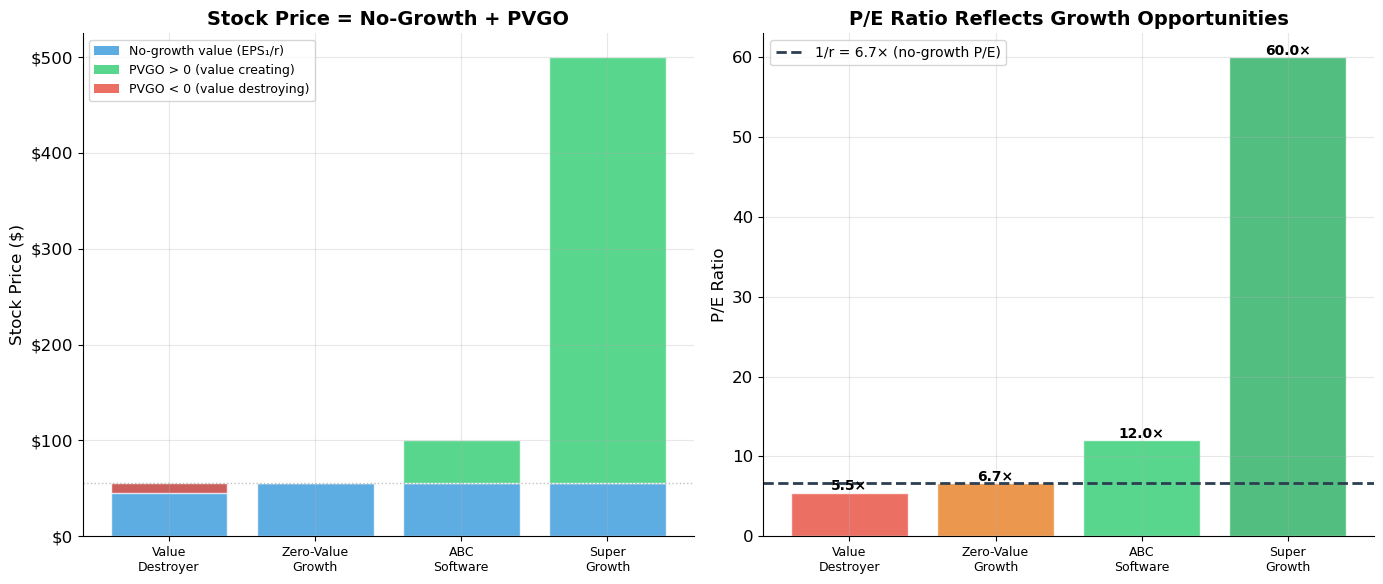

In [22]:
# ============================================================
# PVGO Decomposition — Visualization
# ============================================================

def pvgo_decomposition(EPS1, r, ROE, b):
    """Compute price, no-growth value, and PVGO."""
    g = b * ROE
    D1 = EPS1 * (1 - b)
    if r <= g:
        return float('inf'), EPS1/r, float('inf'), g
    P0 = D1 / (r - g)
    P_nogrowth = EPS1 / r
    PVGO = P0 - P_nogrowth
    return P0, P_nogrowth, PVGO, g

# Compare firms with different ROE
firms = [
    ('Value Destroyer',  8.33, 0.15, 0.10, 0.4),  # ROE < r
    ('Zero-Value Growth', 8.33, 0.15, 0.15, 0.4),  # ROE = r
    ('ABC Software',     8.33, 0.15, 0.25, 0.4),   # ROE > r
    ('Super Growth',     8.33, 0.15, 0.35, 0.4),   # ROE >> r
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

names = []
no_growth_vals = []
pvgo_vals = []
pe_ratios = []

print("=" * 80)
print("PVGO DECOMPOSITION ACROSS FIRMS (all: EPS₁=$8.33, r=15%, b=0.4)")
print("=" * 80)
print(f"{'Firm':>20s} {'ROE':>6s} {'g':>6s} {'P₀':>8s} {'EPS/r':>8s} {'PVGO':>8s} {'P/E':>6s} {'PVGO%':>7s}")
print("-" * 80)

for name, eps, r, roe, b in firms:
    P0, P_ng, pvgo, g = pvgo_decomposition(eps, r, roe, b)
    pe = P0 / eps
    names.append(name.replace(' ', '\n'))
    no_growth_vals.append(P_ng)
    pvgo_vals.append(pvgo)
    pe_ratios.append(pe)
    print(f"{name:>20s} {roe:>6.0%} {g:>6.0%} ${P0:>7.2f} ${P_ng:>7.2f} ${pvgo:>+7.2f} {pe:>6.1f} {pvgo/P0*100:>6.1f}%")

# Left: Stacked bar chart
x = np.arange(len(names))
ax1.bar(x, no_growth_vals, color='#3498db', alpha=0.8, label='No-growth (EPS₁/r)', edgecolor='white')
for i, pv in enumerate(pvgo_vals):
    color = '#2ecc71' if pv >= 0 else '#e74c3c'
    ax1.bar(x[i], pv, bottom=no_growth_vals[i], color=color, alpha=0.8, edgecolor='white')

# Custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', alpha=0.8, label='No-growth value (EPS₁/r)'),
                   Patch(facecolor='#2ecc71', alpha=0.8, label='PVGO > 0 (value creating)'),
                   Patch(facecolor='#e74c3c', alpha=0.8, label='PVGO < 0 (value destroying)')]
ax1.legend(handles=legend_elements, fontsize=9, loc='upper left')

ax1.set_xticks(x)
ax1.set_xticklabels(names, fontsize=9)
ax1.set_ylabel('Stock Price ($)', fontsize=12)
ax1.set_title('Stock Price = No-Growth + PVGO', fontsize=14, fontweight='bold')
ax1.axhline(y=no_growth_vals[0], color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.0f}'))

# Right: P/E ratio
colors_pe = ['#e74c3c', '#e67e22', '#2ecc71', '#27ae60']
ax2.bar(x, pe_ratios, color=colors_pe, alpha=0.8, edgecolor='white')
ax2.axhline(y=1/0.15, color='#2c3e50', linewidth=2, linestyle='--', 
            label=f'1/r = {1/0.15:.1f}× (no-growth P/E)')
ax2.set_xticks(x)
ax2.set_xticklabels(names, fontsize=9)
ax2.set_ylabel('P/E Ratio', fontsize=12)
ax2.set_title('P/E Ratio Reflects Growth Opportunities', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)

for i, pe in enumerate(pe_ratios):
    ax2.text(i, pe + 0.3, f'{pe:.1f}×', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

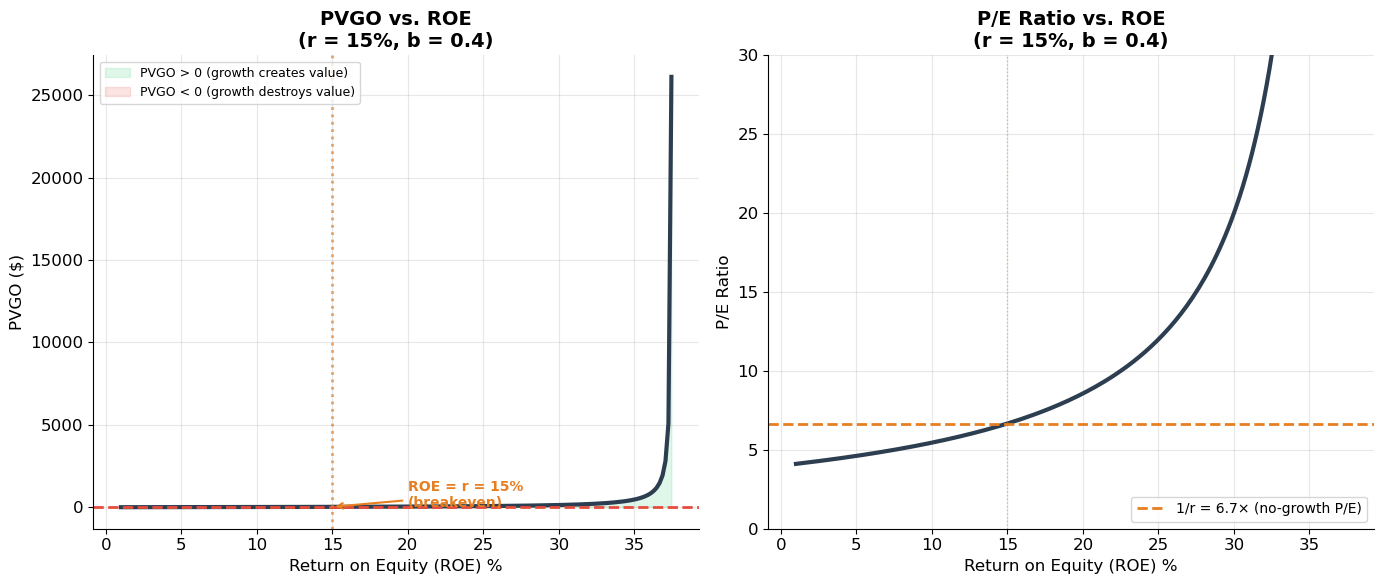

Critical insight:
• ROE > r: Growth creates value → PVGO > 0 → P/E > 1/r (growth stock)
• ROE = r: Growth is value-neutral → PVGO = 0 → P/E = 1/r
• ROE < r: Growth DESTROYS value → PVGO < 0 → P/E < 1/r

A 'growth stock' is defined by ROE > r, NOT by growing EPS!


In [23]:
# ============================================================
# When Does Growth Create/Destroy Value? — ROE vs. r
# ============================================================
EPS1 = 8.33
r = 0.15
b = 0.4

ROE_range = np.linspace(0.01, 0.40, 200)
prices = []
pvgos = []
pes = []

for roe in ROE_range:
    g = b * roe
    if r > g:
        D1 = EPS1 * (1 - b)
        P0 = D1 / (r - g)
        pvgo = P0 - EPS1/r
        prices.append(P0)
        pvgos.append(pvgo)
        pes.append(P0/EPS1)
    else:
        prices.append(np.nan)
        pvgos.append(np.nan)
        pes.append(np.nan)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: PVGO vs ROE
ax1.plot(ROE_range * 100, pvgos, color='#2c3e50', linewidth=3)
ax1.axhline(y=0, color='#e74c3c', linewidth=2, linestyle='--')
ax1.axvline(x=r * 100, color='#e67e22', linewidth=2, linestyle=':', alpha=0.7)
ax1.fill_between(ROE_range * 100, 0, pvgos, where=np.array(pvgos) > 0,
                alpha=0.15, color='#2ecc71', label='PVGO > 0 (growth creates value)')
ax1.fill_between(ROE_range * 100, 0, pvgos, where=np.array(pvgos) < 0,
                alpha=0.15, color='#e74c3c', label='PVGO < 0 (growth destroys value)')

ax1.annotate(f'ROE = r = {r:.0%}\n(breakeven)', xy=(r*100, 0), xytext=(r*100 + 5, -15),
            fontsize=10, color='#e67e22', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#e67e22', lw=1.5))

ax1.set_xlabel('Return on Equity (ROE) %', fontsize=12)
ax1.set_ylabel('PVGO ($)', fontsize=12)
ax1.set_title('PVGO vs. ROE\n(r = 15%, b = 0.4)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)

# Right: P/E vs ROE
ax2.plot(ROE_range * 100, pes, color='#2c3e50', linewidth=3)
ax2.axhline(y=1/r, color='#e67e22', linewidth=2, linestyle='--', label=f'1/r = {1/r:.1f}× (no-growth P/E)')
ax2.axvline(x=r * 100, color='#e67e22', linewidth=1, linestyle=':', alpha=0.5)

ax2.set_xlabel('Return on Equity (ROE) %', fontsize=12)
ax2.set_ylabel('P/E Ratio', fontsize=12)
ax2.set_title('P/E Ratio vs. ROE\n(r = 15%, b = 0.4)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.set_ylim(0, 30)

plt.tight_layout()
plt.show()

print("Critical insight:")
print("• ROE > r: Growth creates value → PVGO > 0 → P/E > 1/r (growth stock)")
print("• ROE = r: Growth is value-neutral → PVGO = 0 → P/E = 1/r")
print("• ROE < r: Growth DESTROYS value → PVGO < 0 → P/E < 1/r")
print("\nA 'growth stock' is defined by ROE > r, NOT by growing EPS!")

---

<a id='8-exercises'></a>
## 8. Exercises

### Exercise 1: Gordon Growth Model

A utility company just paid a dividend of \$3.50 per share. Dividends are expected to grow at 3% per year indefinitely.

**(a)** If the required return is 9%, what is the stock price?

**(b)** If the stock is currently trading at \$65, what cost of equity is the market implying?

**(c)** If management announces it will increase the growth rate to 5% by reducing the payout ratio, but the required return also increases to 11% due to higher risk, what happens to the stock price? Is the growth strategy value-creating?

**(d)** The CEO claims "our stock is undervalued because the market doesn't understand our growth." If the current price is \$55 and r = 9%, what growth rate is the market implying? Is the CEO's claim plausible if ROE = 12%?

In [25]:
# Exercise 1 — Workspace
# D0 = 3.50; g = 0.03; r = 0.09
#
# (a) P0 = D0*(1+g)/(r-g) = 3.50*1.03/(0.09-0.03)
# P0 = ?
#
# (b) Trading at $65: r = D1/P0 + g = 3.50*1.03/65 + 0.03
# r = ?
#
# (c) New g=0.05, new r=0.11
# P0_new = 3.50*(1.05)/(0.11-0.05)
# Compare with original
#
# (d) 55 = 3.50*(1+g)/(0.09-g)  →  solve for g
# from scipy.optimize import brentq
# g_implied = brentq(lambda g: 3.50*(1+g)/(0.09-g) - 55, 0, 0.089)
# print(f"Implied g = {g_implied:.2%}")

### Exercise 2: Two-Stage Growth Model

TechCorp has just paid a dividend of \$1.20. Analysts expect 20% dividend growth for the next 5 years, followed by 4% growth forever. The cost of equity is 14%.

**(a)** Compute the stock price using the two-stage DDM.

**(b)** What fraction of the stock's value comes from the terminal value? Why is this fraction typically so large?

**(c)** If the market prices the stock at \$35, what stable growth rate $g_L$ is being implied (keeping all else equal)? Use numerical methods.

**(d)** Run a sensitivity analysis: how does the stock price change as $g_L$ varies from 2% to 6% and as $r$ varies from 12% to 16%? Present your results as a table.

In [27]:
# Exercise 2 — Workspace
# D0, r, g_H, T, g_L = 1.20, 0.14, 0.20, 5, 0.04
#
# (a)
# pv1, pv2, P0 = two_stage_ddm(D0, r, g_H, T, g_L)
# print(f"P₀ = ${P0:.2f}")
#
# (b)
# print(f"Terminal value share: {pv2/(pv1+pv2)*100:.1f}%")
#
# (c) Find g_L such that P0 = 35
# g_implied = brentq(lambda g: two_stage_ddm(D0, r, g_H, T, g)[2] - 35, 0, 0.139)
# print(f"Implied g_L = {g_implied:.2%}")

### Exercise 3: PVGO and Growth Stocks

MegaCorp has: EPS₁ = \$5.00, payout ratio = 50%, ROE = 18%, cost of equity = 12%.

**(a)** Compute the sustainable growth rate, dividend, stock price, and P/E ratio.

**(b)** Decompose the stock price into no-growth value and PVGO. What fraction of value comes from growth opportunities?

**(c)** A competitor, SteadyCorp, has the same EPS and cost of equity but ROE = 12% (equal to $r$). It also retains 50%. Compute SteadyCorp's price, PVGO, and P/E. What happens if SteadyCorp increases retention to 80%?

**(d)** A value investor argues: "I only buy stocks with P/E < 10. High P/E stocks are overpriced." Using the PVGO framework, explain why this rule might cause the investor to miss excellent opportunities. When might the rule be correct?

In [29]:
# Exercise 3 — Workspace
# EPS1, p, ROE, r = 5.00, 0.50, 0.18, 0.12
# b = 1 - p
# g = b * ROE
# D1 = EPS1 * p
# P0 = D1 / (r - g)
# P_nogrowth = EPS1 / r
# PVGO = P0 - P_nogrowth
# PE = P0 / EPS1
#
# print(f"g = {g:.2%}, D₁ = ${D1:.2f}")
# print(f"P₀ = ${P0:.2f}, P/E = {PE:.1f}×")
# print(f"No-growth: ${P_nogrowth:.2f}, PVGO: ${PVGO:.2f} ({PVGO/P0*100:.1f}%)")

---

## Key Takeaways — Session 6

1. **The DDM** values a stock as the present value of all future dividends: $P_0 = \sum D_t/(1+r)^t$. The holding period doesn't matter — the price reflects the *infinite* dividend stream.

2. **The Gordon Growth Model** $P_0 = D_1/(r-g)$ is the workhorse of equity valuation. It requires $r > g$ and is extremely sensitive to the spread $(r - g)$.

3. **Cost of equity** can be estimated from the DDM: $r = D_1/P_0 + g$ (dividend yield + growth). Returns decompose into income (dividends) and capital gains (growth).

4. **Multi-stage models** handle firms transitioning from high to stable growth. The terminal value (stable phase) typically dominates, accounting for 60–80% of total value.

5. **Sustainable growth** $g = b \times ROE$. The link between dividends and earnings is through the payout ratio.

6. **Stock price = No-growth value + PVGO**. Growth creates value *only* when ROE > $r$. A true "growth stock" is defined by having PVGO > 0, not by having fast-growing EPS.

7. **P/E ratio = $1/r$ + PVGO/EPS**. High P/E signals growth opportunities. P/E equals $1/r$ only when the firm earns exactly its cost of capital on new investments.

---

## References

- **Brealey, R.A., Myers, S.C., and Allen, F.** *Principles of Corporate Finance*, Chapter 4.
- **MIT OCW 15.401:** [Equities](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/equities/)
- **Gordon, M.J.** (1959). "Dividends, Earnings, and Stock Prices." *Review of Economics and Statistics*, 41(2), 99–105.
- **Harris, L.** (2002). *Trading and Exchanges: Market Microstructure for Practitioners*. Oxford University Press.
- **Malkiel, B.** (1996). *A Random Walk Down Wall Street*. W.W. Norton.

---

*Next: **Session 7 — Forward and Futures Contracts** — forward pricing, cost of carry, futures markets, and hedging applications.*